In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, unload

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

## Problem with forward pass hooks

If I instantiate the hook inside the forward pass command for a instance specific feature size, the forward hook is not called.

In [2]:
class SimpleRNN(nn.Module):
    def __init__(self, data_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(data_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = F.softmax
    
    @staticmethod
    def detach(x):
        return Variable(x.data)
        
    def forward(self, x, hidden):
            
        inp = torch.cat((x, hidden), 1)
        self.hidden = self.i2h(inp)
        output = self.h2o(self.hidden)
        return output, self.hidden

In [3]:
source = "1 + 1 = 3;1 + 2 = 3;1 + 3 = 4;1 + 5 = 6;1 + 7 = 8;1 + 9 = 10;4 + 3 = 7;"+\
"4 + 2 = 6;4 + 5 = 9;4 + 1 = 5;4 + 6 = 10;4 + 7 = 11;4 + 8 = 12;"

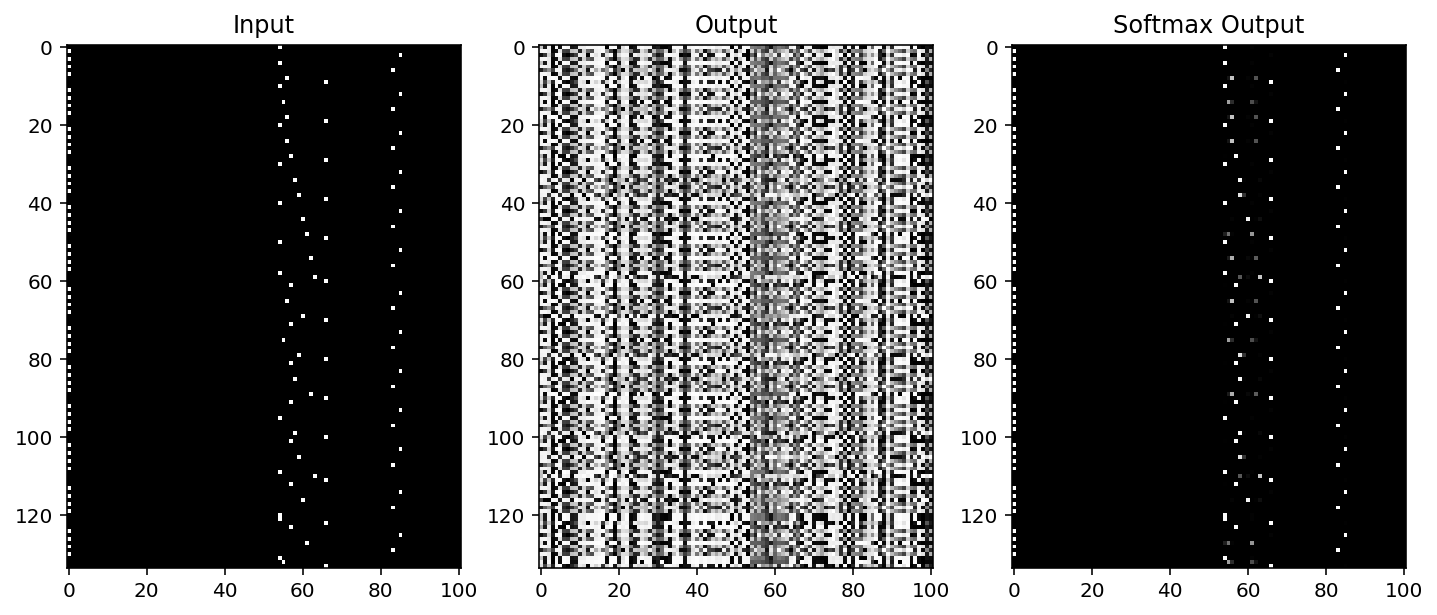

100%|██████████| 25000/25000 [00:18<00:00, 1371.74it/s]


In [4]:
learning_rate = 0.5e-3
char2vec = Char2Vec()
input_size = len(char2vec.chars)
hidden_size = 20
source_length = len(source)
TIME_STEPS = source_length

model = SimpleRNN(input_size, hidden_size, input_size)
loss_fn = nn.CrossEntropyLoss()

input_vec = Variable(torch.FloatTensor(list(map(char2vec.one_hot, source))))
target_vec = Variable(torch.LongTensor(list(map(char2vec.char_code, source))))

hidden = Variable(torch.randn(source_length, hidden_size))    
loss = 0
for step in tqdm(range(25000)):
        
    hidden = model.detach(hidden)
    output, hidden = model(input_vec, hidden)
    loss = loss_fn(output.view(-1, input_size), target_vec)
    
    if step%2000 == 1999:
        clear_output(wait=True)
        plt.figure(figsize=(12, 9))
        plt.subplot(131)
        plt.title("Input")
        plt.imshow(input_vec.data.byte().numpy(), cmap="Greys_r", interpolation="none")
        plt.subplot(132)
        plt.title("Output")
        plt.imshow(output.data.byte().numpy(), cmap="Greys_r", interpolation="none")
        plt.subplot(133)
        plt.title("Softmax Output")
        plt.imshow(model.softmax(output).cpu().data.numpy(), cmap="Greys_r", interpolation="none")
        plt.show()
        
    model.zero_grad()
    loss.backward()
    
    for p in model.parameters():
        # print(p.grad)
        p.data -= learning_rate * p.grad.data
        
    #optimizer = optim.Adam(model.parameters(), lr=1e-2)

## Writing the gradient descent with an optimizer

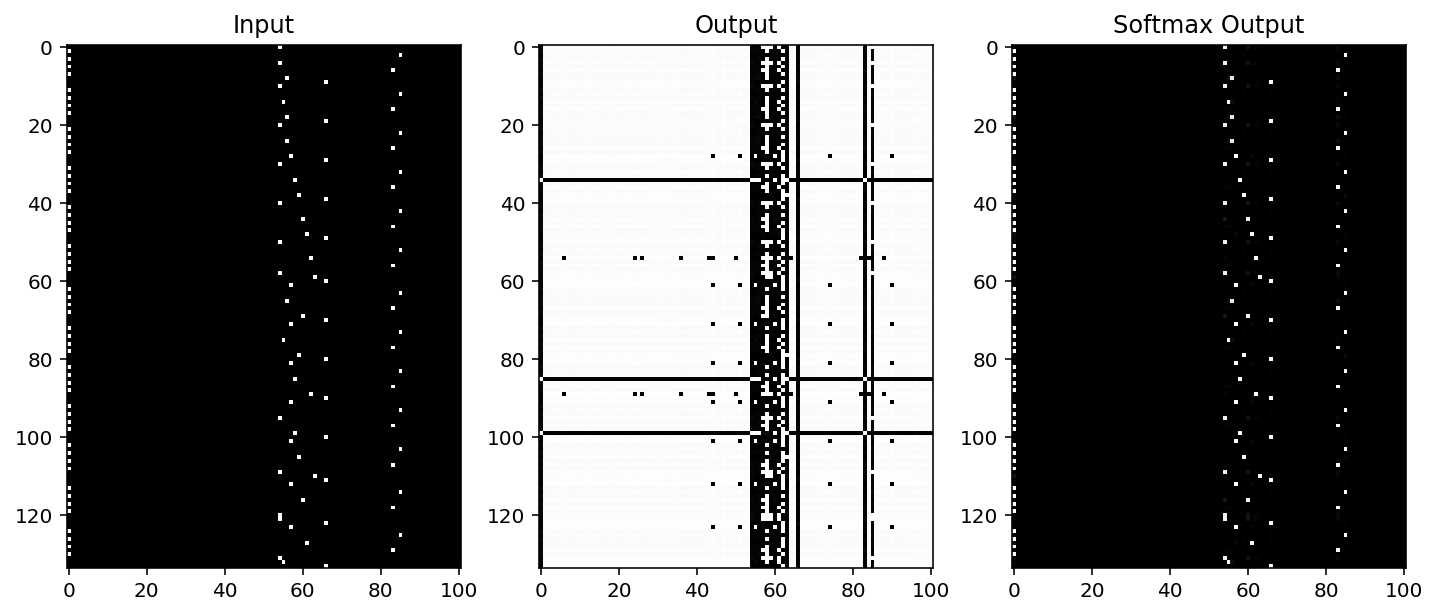

100%|██████████| 2500/2500 [00:01<00:00, 1473.70it/s]


In [5]:
learning_rate = 1e-3
char2vec = Char2Vec()
input_size = len(char2vec.chars)
hidden_size = 20
source_length = len(source)
TIME_STEPS = source_length

model = SimpleRNN(input_size, hidden_size, input_size)
loss_fn = nn.CrossEntropyLoss()

input_vec = Variable(torch.FloatTensor(list(map(char2vec.one_hot, source))))
target_vec = Variable(torch.LongTensor(list(map(char2vec.char_code, source))))

hidden = Variable(torch.randn(source_length, hidden_size))    
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for step in tqdm(range(2500)):
        
    hidden = model.detach(hidden)
    output, hidden = model(input_vec, hidden)
    loss = loss_fn(output.view(-1, input_size), target_vec)
    
    if step%2000 == 1999:
        clear_output(wait=True)
        plt.figure(figsize=(12, 9))
        plt.subplot(131)
        plt.title("Input")
        plt.imshow(input_vec.data.byte().numpy(), cmap="Greys_r", interpolation="none")
        plt.subplot(132)
        plt.title("Output")
        plt.imshow(output.data.byte().numpy(), cmap="Greys_r", interpolation="none")
        plt.subplot(133)
        plt.title("Softmax Output")
        plt.imshow(model.softmax(output).cpu().data.numpy(), cmap="Greys_r", interpolation="none")
        plt.show()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Now use the network to infer equations

In [6]:
from ipywidgets import widgets
from IPython.display import display

In [7]:
def predict_next(source):
    
    clear_output()
    
    source_length = len(source)
    input_vec = Variable(torch.FloatTensor(list(map(char2vec.one_hot, source))))
    
    hidden = Variable(torch.zeros(source_length, hidden_size))    
    
    output, hidden = model(input_vec, hidden)
    
    softmax_output = model.softmax(output).cpu().data.numpy()
    
    
    
    string_output = ''.join([char2vec.chars[row.argmax()] for row in softmax_output])
    
    print(string_output)
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(input_vec.data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(output.data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(softmax_output, cmap="Greys_r", interpolation="none")
    plt.show()

1 + 4 = 


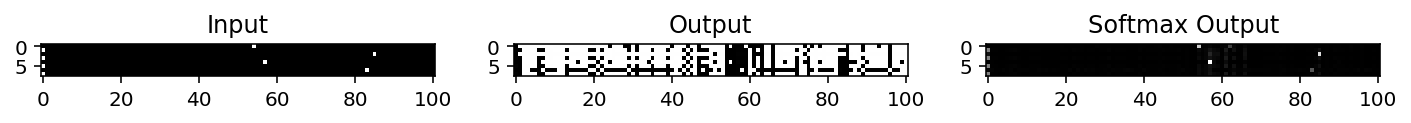

In [8]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value)
    
text_input.on_submit(handle_submit)

Obviously the prediction is still pretty bad :joy: